In [1]:
import pandas as pd
from scipy import stats
import os
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "plotly_mimetype"

# --- Configuration (from your existing code) ---
csv_file_path = r"D:\Career\Projects\Data Analyst\AirPure Innovations\data\processed\csv\aqi_clean.csv"
output_dir = r"D:\Career\Projects\Data Analyst\AirPure Innovations\data\processed\csv"
metro_cities = [
    "Delhi", "Mumbai", "Chennai", "Kolkata",
    "Bengaluru", "Hyderabad", "Ahmedabad", "Pune"
]

# --- Data Loading and Initial Cleaning (from your existing code) ---
aqi_df = pd.DataFrame() # Initialize to avoid NameError
if not os.path.exists(csv_file_path):
    print(f"Error: CSV file not found at {csv_file_path}")
    print("Please ensure the file path is correct and the file exists.")
else:
    try:
        aqi_df = pd.read_csv(csv_file_path, encoding='latin1')
        aqi_df.columns = aqi_df.columns.str.strip().str.lower()
        if 'aqi_value' in aqi_df.columns:
            aqi_df = aqi_df.rename(columns={'aqi_value': 'aqi'})
        required_cols = {'date', 'area', 'aqi'}
        missing_cols = required_cols - set(aqi_df.columns)
        if missing_cols:
            raise ValueError(f"The input data must contain these columns: {missing_cols}")
        aqi_df['date'] = pd.to_datetime(aqi_df['date'], errors='coerce')
        aqi_df = aqi_df.dropna(subset=['date'])
        aqi_df['aqi'] = pd.to_numeric(aqi_df['aqi'], errors='coerce')
        aqi_df = aqi_df.dropna(subset=['aqi'])
    except Exception as e:
        print(f"An error occurred during data loading or initial processing: {e}")

# --- Data Filtering and Transformation (from your existing code) ---
if not aqi_df.empty:
    today = pd.Timestamp.now().normalize()
    one_year_ago = today - pd.DateOffset(years=1)
    recent_data = aqi_df[aqi_df['date'] >= one_year_ago].copy()
    metro_df = recent_data[recent_data['area'].isin(metro_cities)].copy()
    metro_df['day_of_week'] = metro_df['date'].dt.dayofweek
    metro_df['is_weekend'] = metro_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    metro_df['day_type'] = metro_df['is_weekend'].map({1: 'Weekend', 0: 'Weekday'})

    # --- Calculate Average AQI for Weekday vs Weekend ---
    avg_aqi_df = metro_df.groupby(['area', 'day_type'])['aqi'].mean().reset_index()
    avg_aqi_df.rename(columns={'aqi': 'average_aqi'}, inplace=True)

    # --- Visualization: Average AQI Bar Chart ---
    fig_avg_aqi = px.bar(
        avg_aqi_df,
        x='area',
        y='average_aqi',
        color='day_type',
        barmode='group',
        title='Average AQI on Weekdays vs. Weekends in Indian Metro Cities (Last 1 Year)',
        labels={
            'area': 'Metro City',
            'average_aqi': 'Average AQI Value',
            'day_type': 'Day Type'
        },
        color_discrete_map={'Weekday': 'blue', 'Weekend': 'orange'},
        hover_data={'average_aqi': ':.2f'}
    )

    fig_avg_aqi.update_layout(
        xaxis_title="Metro City",
        yaxis_title="Average AQI Value",
        legend_title_text='Day Type',
        hovermode="x unified"
    )
    fig_avg_aqi.show()

    # --- Perform T-test for each city (from your existing code) ---
    significance_results = []
    for city in metro_cities:
        weekend_aqi = metro_df[(metro_df['area'] == city) & (metro_df['is_weekend'] == 1)]['aqi']
        weekday_aqi = metro_df[(metro_df['area'] == city) & (metro_df['is_weekend'] == 0)]['aqi']
        if len(weekend_aqi) > 1 and len(weekday_aqi) > 1:
            t_stat, p_value = stats.ttest_ind(weekend_aqi, weekday_aqi, equal_var=False)
            significance_results.append({
                'area': city,
                't_statistic': round(t_stat, 3),
                'p_value': round(p_value, 4),
                'is_significant': p_value < 0.05
            })
        else:
            significance_results.append({
                'area': city,
                't_statistic': None,
                'p_value': None,
                'is_significant': False
            })
    significance_df = pd.DataFrame(significance_results)

    # --- Visualization: T-Statistic and Significance ---
    significance_df['is_significant_str'] = significance_df['is_significant'].astype(str)

    fig_t_stat = px.bar(
        significance_df,
        x='area',
        y='t_statistic',
        color='is_significant_str',
        color_discrete_map={'True': 'green', 'False': 'red'},
        title='T-Statistic for Weekend vs. Weekday AQI Comparison',
        labels={
            'area': 'Metro City',
            't_statistic': 'T-Statistic',
            'is_significant_str': 'Statistically Significant (p < 0.05)'
        },
        hover_data=['p_value']
    )
    fig_t_stat.add_hline(y=0, line_dash="dot", line_color="gray")
    fig_t_stat.update_layout(
        xaxis_title="Metro City",
        yaxis_title="T-Statistic (Positive = Weekend AQI > Weekday AQI)",
        bargap=0.2,
        showlegend=True,
        legend_title_text='Significance'
    )
    fig_t_stat.show()

    # --- Visualization: P-Value and Significance ---
    fig_p_value = px.bar(
        significance_df,
        x='area',
        y='p_value',
        color='is_significant_str',
        color_discrete_map={'True': 'green', 'False': 'red'},
        title='P-Value for Weekend vs. Weekday AQI Comparison',
        labels={
            'area': 'Metro City',
            'p_value': 'P-Value',
            'is_significant_str': 'Statistically Significant (p < 0.05)'
        },
        hover_data=['t_statistic']
    )
    fig_p_value.add_hline(y=0.05, line_dash="dot", line_color="blue", annotation_text="Significance Level (0.05)", annotation_position="top right")
    fig_p_value.update_layout(
        xaxis_title="Metro City",
        yaxis_title="P-Value",
        bargap=0.2,
        showlegend=True,
        legend_title_text='Significance'
    )
    fig_p_value.show()

else:
    print("No data processed due to errors or empty input DataFrame.")


### ❓ Research Question

**Does the Air Quality Index (AQI) improve on weekends compared to weekdays in major Indian metro cities (Delhi, Mumbai, Chennai, Kolkata, Bengaluru, Hyderabad, Ahmedabad, Pune)?**

This analysis uses AQI data from the last 1 year to examine whether reduced weekday activity (e.g., traffic and industry) leads to better air quality on weekends.


### 🧼 Data Preparation

We filter and clean the AQI data:
- Retain only valid dates and AQI values
- Filter the data to the **last 1 year**
- Focus on **8 Indian metro cities**
- Classify each record as **Weekday** or **Weekend**

Below is the cleaned and filtered dataset preview:


In [2]:
display(metro_df.head(5))

,date,state,area,number_of_monitoring_stations,prominent_pollutants,aqi,air_quality_status,unit,note,date_year,date_month,date_day,day_of_week,is_weekend,day_type
11,2025-04-30,Gujarat,Ahmedabad,8,"PM2.5,PM10",110,Moderate,number_of_monitoring_stations in Absolute Numb...,NaN,2025,April,Wednesday,2,0,Weekday
34,2025-04-30,Tamil Nadu,Chennai,7,"PM10,O3,CO",46,Good,number_of_monitoring_stations in Absolute Numb...,NaN,2025,April,Wednesday,2,0,Weekday
92,2025-04-30,West Bengal,Kolkata,6,"PM10,NO2",65,Satisfactory,number_of_monitoring_stations in Absolute Numb...,NaN,2025,April,Wednesday,2,0,Weekday
95,2025-04-30,Telangana,Hyderabad,11,"PM2.5,PM10",74,Satisfactory,number_of_monitoring_stations in Absolute Numb...,NaN,2025,April,Wednesday,2,0,Weekday
99,2025-04-30,Karnataka,Bengaluru,13,"PM2.5,PM10",84,Satisfactory,number_of_monitoring_stations in Absolute Numb...,NaN,2025,April,Wednesday,2,0,Weekday


In [3]:
import plotly.express as px

fig_avg_aqi = px.bar(
    avg_aqi_df,
    x="area",
    y="average_aqi",
    color="day_type",
    barmode="group",
    title="Average AQI on Weekdays vs. Weekends in Indian Metro Cities (Last 1 Year)",
    labels={
        "area": "Metro City",
        "average_aqi": "Average AQI Value",
        "day_type": "Day Type",
    },
    hover_data={"average_aqi": ":.2f"},
)
fig_avg_aqi.show()

### 📊 Analysis: AQI Patterns - Weekday vs. Weekend

The bar chart visualization comparing weekday and weekend Air Quality Index (AQI) levels across 8 major Indian metro cities reveals several interesting patterns:

- **Delhi** shows the highest AQI levels overall (>200), indicating "Poor" air quality, with a slight improvement on weekends compared to weekdays
- **Ahmedabad, Pune,** and **Kolkata** exhibit "Moderate" air quality (AQI 100-150)
- **Mumbai, Hyderabad,** and **Bengaluru** maintain "Satisfactory" levels (AQI 50-100)
- **Chennai** consistently shows the best air quality among the metros studied

Most cities show minimal differences between weekday and weekend AQI values, suggesting that day-to-day urban activities may not significantly impact short-term air quality. The consistency indicates that persistent pollution sources (like industrial emissions, construction, or geographical factors) likely contribute more to air quality than temporary reductions in commuter traffic.

### 📊 T-Test Analysis: Weekend vs. Weekday AQI

We used Welch’s t-test to compare average AQI between **weekdays** and **weekends** for each metro city.

The null hypothesis (H₀): There is **no difference** in AQI between weekends and weekdays.
The alternative hypothesis (H₁): There **is a difference** in AQI between weekends and weekdays.

In [4]:
display(significance_df)

,area,t_statistic,p_value,is_significant,is_significant_str
0,Delhi,-0.929,0.3543,False,False
1,Mumbai,0.433,0.6654,False,False
2,Chennai,-1.250,0.2131,False,False
3,Kolkata,-0.014,0.9886,False,False
4,Bengaluru,0.104,0.9176,False,False
5,Hyderabad,0.099,0.9210,False,False
6,Ahmedabad,0.526,0.5998,False,False
7,Pune,-0.148,0.8827,False,False


### 📈 Visualizations

Let’s visualize the results to quickly understand where (if anywhere) weekends show a statistically significant AQI change.

In [5]:
fig_t_stat.show()

In [6]:
fig_p_value.show()  # already defined in your code

### 🧾 Conclusion

After analyzing AQI levels in major Indian metro cities:

- **None of the cities show a statistically significant difference (p < 0.05) in AQI between weekdays and weekends.**
- This suggests that **AQI remains largely consistent throughout the week**, possibly due to continuous pollution sources like construction, industry, or persistent traffic.

✅ This analysis **answers our research question**:
> **No, AQI does not significantly improve on weekends across Indian metro cities.**

In [7]:
import os

# Define the output file path using the existing output directory
significance_output_path = os.path.join(output_dir, "aqi_significance_results.csv")

# Export the significance test results
significance_df.to_csv(significance_output_path, index=False)

# Display a confirmation message
print(f"Statistical significance results exported to: {significance_output_path}")

# Optional: Add more details to the export
# Create an enhanced version with additional information
significance_enhanced = significance_df.copy()
significance_enhanced["weekday_avg"] = [
    avg_aqi_df[(avg_aqi_df["area"] == city) & (avg_aqi_df["day_type"] == "Weekday")][
        "average_aqi"
    ].values[0]
    for city in significance_enhanced["area"]
]
significance_enhanced["weekend_avg"] = [
    avg_aqi_df[(avg_aqi_df["area"] == city) & (avg_aqi_df["day_type"] == "Weekend")][
        "average_aqi"
    ].values[0]
    for city in significance_enhanced["area"]
]
significance_enhanced["difference"] = (
    significance_enhanced["weekend_avg"] - significance_enhanced["weekday_avg"]
)

# Export the enhanced version
enhanced_output_path = os.path.join(output_dir, "aqi_significance_detailed.csv")
significance_enhanced.to_csv(enhanced_output_path, index=False)

print(f"Enhanced statistical results exported to: {enhanced_output_path}")

Statistical significance results exported to: D:\Career\Projects\Data Analyst\AirPure Innovations\data\processed\csv\aqi_significance_results.csv
Enhanced statistical results exported to: D:\Career\Projects\Data Analyst\AirPure Innovations\data\processed\csv\aqi_significance_detailed.csv


In [8]:
# Export the average AQI by metro city and day type to CSV
avg_aqi_output_path = os.path.join(output_dir, "avg_metro_city_aqi.csv")
avg_aqi_df.to_csv(avg_aqi_output_path, index=False)

# Create a more detailed monthly analysis
monthly_aqi = metro_df.groupby(['area', pd.Grouper(key='date', freq='M'), 'day_type'])['aqi'].mean().reset_index()
monthly_aqi.rename(columns={'aqi': 'average_aqi'}, inplace=True)
monthly_aqi['year_month'] = monthly_aqi['date'].dt.strftime('%Y-%m')

# Export monthly data
monthly_aqi_path = os.path.join(output_dir, "monthly_metro_city_aqi.csv")
monthly_aqi.to_csv(monthly_aqi_path, index=False)

print(f"Average AQI by metro city exported to: {avg_aqi_output_path}")
print(f"Monthly AQI analysis exported to: {monthly_aqi_path}")

Average AQI by metro city exported to: D:\Career\Projects\Data Analyst\AirPure Innovations\data\processed\csv\avg_metro_city_aqi.csv
Monthly AQI analysis exported to: D:\Career\Projects\Data Analyst\AirPure Innovations\data\processed\csv\monthly_metro_city_aqi.csv


C:\Users\sadiq\AppData\Local\Temp\ipykernel_6568\4118700521.py:6: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



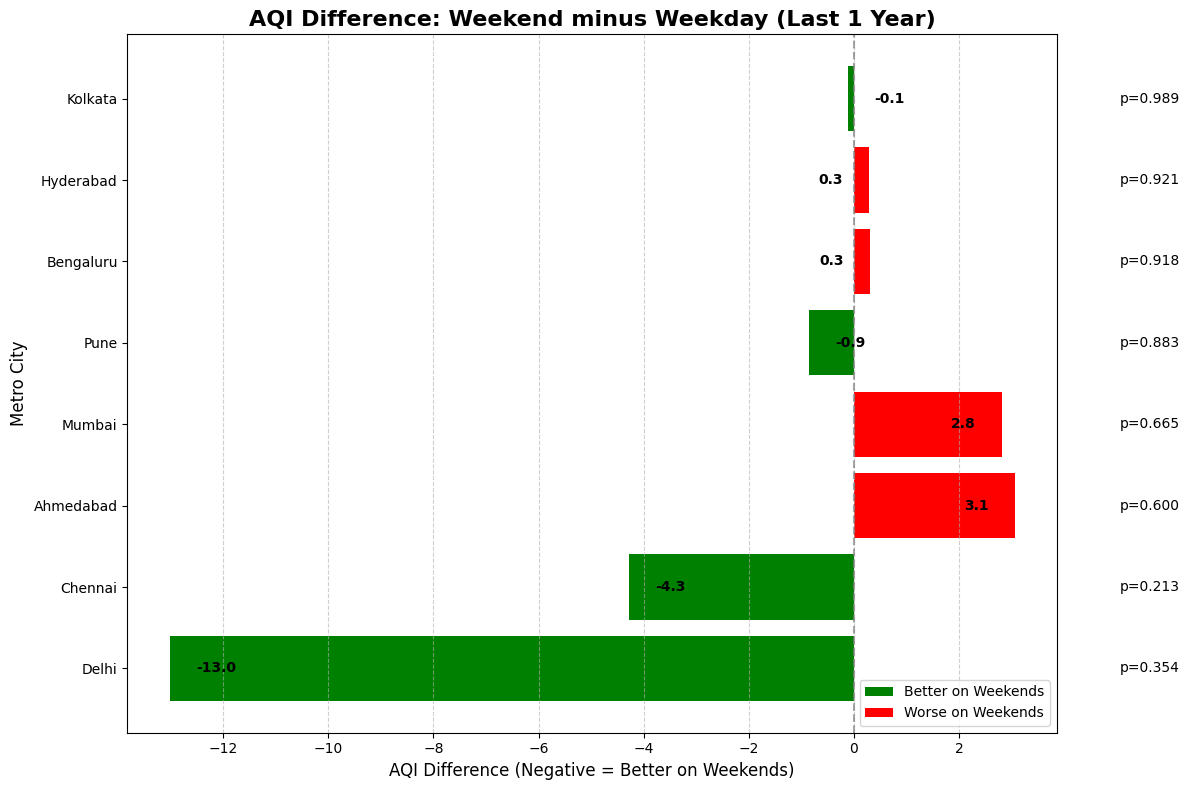

In [19]:
import pandas as pd
import seaborn as sns
from matplotlib.patches import Patch

import matplotlib.pyplot as plt

# Create a summary dataframe for visual representation
aqi_weekend_weekday_summary = pd.DataFrame({
  'City': significance_enhanced['area'],
  'Weekday AQI': significance_enhanced['weekday_avg'],
  'Weekend AQI': significance_enhanced['weekend_avg'],
  'Difference': significance_enhanced['difference'],
  'P-value': significance_enhanced['p_value'],
  'Better on Weekends': significance_enhanced['difference'] < 0
})

# Sort cities by the absolute magnitude of difference
aqi_weekend_weekday_summary['Abs Difference'] = aqi_weekend_weekday_summary['Difference'].abs()
aqi_weekend_weekday_summary = aqi_weekend_weekday_summary.sort_values('Abs Difference', ascending=False).drop('Abs Difference', axis=1)

# Export the summary to CSV
enhanced_output_path = os.path.join(output_dir, "aqi_weekend_weekday_summary.csv")
aqi_weekend_weekday_summary.to_csv(enhanced_output_path, index=False)

# Set color palette for the plot
colors = ['green' if better else 'red' for better in aqi_weekend_weekday_summary['Better on Weekends']]

# Create a horizontal bar chart showing the differences
plt.figure(figsize=(12, 8))
bars = plt.barh(aqi_weekend_weekday_summary['City'], aqi_weekend_weekday_summary['Difference'], color=colors)

# Add vertical line at zero
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.7)

# Customize the plot
plt.title('AQI Difference: Weekend minus Weekday (Last 1 Year)', fontsize=16, fontweight='bold')
plt.xlabel('AQI Difference (Negative = Better on Weekends)', fontsize=12)
plt.ylabel('Metro City', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Add value labels
for bar in bars:
  width = bar.get_width()
  label_x_pos = width + 0.5 if width < 0 else width - 0.5
  label_ha = 'left' if width < 0 else 'right'
  plt.text(label_x_pos, bar.get_y() + bar.get_height()/2, 
       f'{width:.1f}', ha=label_ha, va='center', 
       color='black', fontweight='bold')

# Add a legend
legend_elements = [
  Patch(facecolor='green', label='Better on Weekends'),
  Patch(facecolor='red', label='Worse on Weekends')
]
plt.legend(handles=legend_elements, loc='lower right')

# Add p-value annotations
for i, (city, p_val) in enumerate(zip(aqi_weekend_weekday_summary['City'], aqi_weekend_weekday_summary['P-value'])):
  plt.text(max(aqi_weekend_weekday_summary['Difference'])+2, i, f'p={p_val:.3f}', va='center')

plt.tight_layout()
plt.show()
